# Santander Coders - Let's Code
## Projeto do módulo de Estatística - jan/2022
## Projeto - Análise do dataset "Wine Quality"

O projeto proposto aos alunos do módulo de Estatística da turma 806 - Santander Coders - faz parte dos critérios de avaliação do módulo e proporciona uma vivência de aplicação de alguns dos tópicos discutidos durante o módulo. O Projeto A - Análise do dataset "Wine Quality" visa explorar técnicas de regressão a partir de um banco de dados disponível (plataforma UCI).  
A análise deve ser desenvolvida considerando três etapas principais (1- EDA, 2 - Regressão Linear, 3- Regressão Logística) principais permeando uma narrativa crítica sobre testes e resultados, aprofundando a aplicação dos métodos vistos em aula.

#### Grupo:
- [Henrique Castro](https://github.com/HenriqueCastros)
- [Samya de Lara Pinheiro](https://github.com/samyadelara)
- [Vitor V.M. Quintella](https://github.com/vitorquintella) 
- [Vitor Freitas Xavier Soares](https://github.com/vfxsoares)

A análise visa a análise de um banco de dados originalmente utilizado por [Cortes e colaboradores (2009)](http://dx.doi.org/10.1016/j.dss.2009.05.016), contendo dados sobre diversas características físico químicas
O grupo Wine3 apresenta neste notebook a análise referida, incluindo uma etapa de importação e pré-tratamento dos dados:  

**Importação e Pré-Tratamento**  
**EDA**  
**Regressão Linear**  
**Regressão Logística**


# Importação e Pré-Tratamento

Nesta sessão é feito o carregamento do banco de dados a partir do site [UCI](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/), e pré-processada a base de dados. Dois arquivos do tipo `csv` estão disponíveis na plataforma, um caracterizando vinhos do tipo tinto e outro do tipo branco. Ambas as bases foram carregadas individualmente (`red_df_raw` e `white_df_raw`).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
uci_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/"
red_df_raw= pd.read_csv(uci_url + 'winequality-red.csv', sep =';')
white_df_raw = pd.read_csv(uci_url + 'winequality-white.csv', sep =';')

As bases de cada tipo foram consolidadas em um único *Pandas dataframe*, contendo variáveis adicionais para *tipo*, *tipo_ID* e *label de classificação (bom ou ruim)*: `df_raw`.  
Contudo, é importante ressaltar que para o aprendizado de máquina foi adotada a abordagem de partição de cada base em três *datasets*:  
- **Treino** (conjunto de dados utilizado para o aprendizado e parametrização dos modelos, isto é, utilizado pelos algoritmos de aprendizado - neste caso de regressão - para calcular os parâmetros dos modelos)
- **Validação** (conjunto de dados utilizado para uma avaliação dos modelos definidos a partir da base de treino, enquanto são ajustados hiperparâmetros, selecionadas veriáveis ou pontos de corte - *threshold cut-offs*)
- **Teste** (conjunto de dados utilizado para uma análise não viesada do ajuste final do model após a etapa de treino)
Assim, previamente à consolidação foi feita a partição da base de *Teste* separadamente nas bases de vinhos tintos (*red*) e brancos (*branco*) para garantir representatividade da distribuição de tipos de vinho na base de avaliação final utilizando a função `train_test_split` do módulo `model_selection` no *Scikit learn*. As bases de *Treino* e *Validação* foram processadas posteriormente nas sessões de Regressão.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data in 10% for test dataset
# And use 70% of remaining data to Training.

test_size = 0.10

X_red = red_df_raw.iloc[:,:-1 ].values
y_red = red_df_raw.loc[:, ['quality']].values
X_white = white_df_raw.iloc[:,:-1 ].values
y_white = white_df_raw.loc[:, ['quality']].values

# In the first step we will split the data in test and remaining dataset
X_red_rem, X_red_test, y_red_rem, y_red_test = train_test_split(X_red,y_red, test_size=test_size, random_state=42)
X_white_rem, X_white_test, y_white_rem, y_white_test = train_test_split(X_white,y_white, test_size=test_size, random_state=42)

# Agrupando dados para retornar à configuração inicial
red_df = pd.concat([pd.DataFrame(X_red_rem), pd.DataFrame(y_red_rem)], axis=1)
red_df.columns = red_df_raw.columns
white_df = pd.concat([pd.DataFrame(X_white_rem), pd.DataFrame(y_white_rem)], axis=1)
white_df.columns = white_df_raw.columns

red_df_test = pd.concat([pd.DataFrame(X_red_test), pd.DataFrame(y_red_test)], axis=1)
red_df_test.columns = red_df_raw.columns
white_df_test = pd.concat([pd.DataFrame(X_white_test), pd.DataFrame(y_white_test)], axis=1)
white_df_test.columns = white_df_raw.columns

# Concatena dados para criar dataframe com ambos os tipos de vinhos
white_df['type'] = 'white'
red_df['type'] = 'red'
df_raw = pd.concat([white_df, red_df])
df_raw = df_raw.reset_index()
df_raw['ID'] =  df_raw['type'] + '_' + df_raw['index'].astype(str)  
df_raw = df_raw.drop('index', 1)
df_raw['is_good'] = df_raw['quality'].apply(lambda x : 0 if x <= 5 else 1)

white_df_test['type'] = 'white'
red_df_test['type'] = 'red'
df_test = pd.concat([white_df_test, red_df_test])
df_test = df_test.reset_index()
df_test['ID'] =  df_test['type'] + '_' + df_test['index'].astype(str)  
df_test = df_test.drop('index', 1)
df_test['is_good'] = df_test['quality'].apply(lambda x : 0 if x <= 5 else 1)


# Análise estatística descritiva - EDA

O banco de dados consolidado, `df_raw`, apresenta 5847 registros (vinhos), caracterizados por 15 variáveis. A qualidade do vinho é uma variável quantitativa discreta [0,10] que atribui uma nota a cada vinho. As 11 primeiras variáveis do banco são parâmetros registrados a partir de testes físico-químicos (variáveis quantitativas contínuas).   
A análise proposta no projeto visa avaliar se é possível estabelecer uma associação entre *qualidade* (variável resposta) e *características físico-químicas* (variáveis explicativas), a partir de modelos supervisionados. Assim, o processo de EDA foi direcionado para descrever o comportamento destas variáveis, incluindo uma visão estratificada por tipos de vinhos (tinto/red x white/branco).  

Algumas variáveis explicativas aparentam um comportamento normal a partir da análise visual dos histogramas, contudo não isentas a assimetrias (`fixed acidity`, `citric acid`, `density`, `ph`, `sulphates` e `alcohol`). Através da análise de algumas métricas descritivas (`df_raw_describe`), foi observado que em muitos destes casos o desvio padrão era uma ordem de grandeza abaixo da média. Contudo, não foram aplicados testes específicos de análise de normalidade, como Shapiro-Wilk, para as variáveis da base de dados, uma vez que os modelos supervisionados a serem propostos não partem da premissa de normalidade.

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5847 entries, 0 to 5846
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5847 non-null   float64
 1   volatile acidity      5847 non-null   float64
 2   citric acid           5847 non-null   float64
 3   residual sugar        5847 non-null   float64
 4   chlorides             5847 non-null   float64
 5   free sulfur dioxide   5847 non-null   float64
 6   total sulfur dioxide  5847 non-null   float64
 7   density               5847 non-null   float64
 8   pH                    5847 non-null   float64
 9   sulphates             5847 non-null   float64
 10  alcohol               5847 non-null   float64
 11  quality               5847 non-null   int64  
 12  type                  5847 non-null   object 
 13  ID                    5847 non-null   object 
 14  is_good               5847 non-null   int64  
dtypes: float64(11), int64

In [ ]:
df_raw

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,ID,is_good
0,7.6,0.290,0.42,1.3,0.035,18.0,86.0,0.99080,2.99,0.39,11.3,5,white,white_0,0
1,6.4,0.380,0.24,7.2,0.047,41.0,151.0,0.99604,3.11,0.60,9.2,5,white,white_1,0
2,7.5,0.320,0.49,1.7,0.031,44.0,109.0,0.99060,3.07,0.46,12.5,6,white,white_2,1
3,6.5,0.260,0.43,8.9,0.083,50.0,171.0,0.99650,2.85,0.50,9.0,5,white,white_3,0
4,6.0,0.140,0.37,1.2,0.032,63.0,148.0,0.99185,3.32,0.44,11.2,5,white,white_4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5842,9.1,0.600,0.00,1.9,0.058,5.0,10.0,0.99770,3.18,0.63,10.4,6,red,red_1434,1
5843,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9,6,red,red_1435,1
5844,7.2,0.620,0.06,2.7,0.077,15.0,85.0,0.99746,3.51,0.54,9.5,5,red,red_1436,0
5845,7.9,0.200,0.35,1.7,0.054,7.0,15.0,0.99458,3.32,0.80,11.9,7,red,red_1437,1


In [ ]:
_deepnote_run_altair(red_df_raw, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"bar","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"alcohol","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"COUNT(*)","type":"quantitative","sort":null,"aggregate":"count","scale":{"type":"linear","zero":true}},"color":{"field":"quality","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [ ]:
df_raw.describe().loc[['min','max','mean', 'std']].round(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_good
min,3.80,0.08,0.00,0.60,0.01,1.00,6.00,0.99,2.72,0.22,8.00,3.00,0.00
max,15.90,1.58,1.66,65.80,0.61,289.00,440.00,1.04,4.01,2.00,14.90,9.00,1.00
mean,7.22,0.34,0.32,5.46,0.06,30.58,115.69,0.99,3.22,0.53,10.49,5.82,0.63
std,1.30,0.17,0.15,4.78,0.04,17.78,56.19,0.00,0.16,0.15,1.19,0.87,0.48


A variável resposta, *qualidade* apresenta uma característica discreta e, apesar da sua definição cobrir valores de 0 a 10, apresentou um range de [3,9]. A base consolidada apresenta maior número de vinhos de tipo branco/white, e as notas 5 e 6 foram registradas com maior frequência, sendo 5.82 a nota média.  
Os histogramas desta variável indicam algumas ocorrências mais extremas, indicando potencial presença de outliers. Esta análise será aprofundada com uso dos boxplots em sessão a seguir.

In [ ]:
#cores padrão para discreminação do tipo de vinho
cores = {type: "darkred" if type == "red" else "palegoldenrod" for type in df_raw.type.unique()}

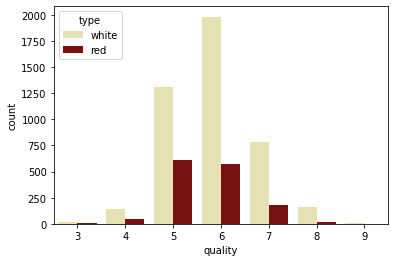

In [ ]:
sns.countplot(x=df_raw['quality'], hue=df_raw['type'], palette = cores);

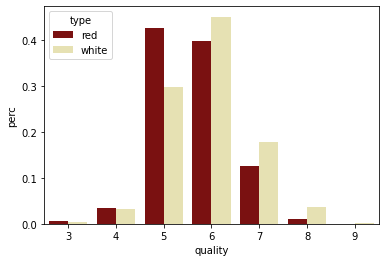

In [ ]:
df_perc =(df_raw.groupby('type')['quality'].value_counts(normalize=True).rename('perc').reset_index())
sns.barplot(x="quality", y='perc', hue='type', data=df_perc, palette = cores);


## Análise de correlações

O aprofundamento da análise descritiva partiu da análise de correlações entre as variáveis, com enfoque nas correlações mais expressivas com a variável resposta de interesse. O gráfico do tipo *mapa de calor* foi utilizado para destacar tais as correlações considerando banco de dados todo e estratificado por tipo.  
A maior correlação detectada foi entre `free sulphur dioxide` e `total sulphur dioxide`, 0.72. Este comportamento era esperado uma vez que uma variável é parte da outra. A variável `densidade` pode ser considerada como uma boa característica resumo do vinho, uma vez que apresenta correlações mais expressivas com diversas outras variáveis (`fixed acid`, `volatile acid`, `residual sugar`, `chlorides`, `sulphates` e `alcohol`). `Quality` está mais correlacionado com `alcohol`, `density` e `volatile acidity`. No presente contexto, alta correlação está sendo definido de forma relativa a partir de um threshold de *igual ou acima de 0.2* ou *igual ou abaixo de -0.2*.  
Estes padrões de correlação não são necessariamente observáveis quando a análise de correlação é feita de forma estratificada pelo tipo de vinho. Isso indica que potencialmente uma análise utilizando também o `type` como variável preditora, ou feita de forma estratificada, pode aprimorar a performance dos modelos de aprendizado.

Text(0.5, 0.98, 'Correlações entre variáveis - Wine dataset\n Branco e Tinto')

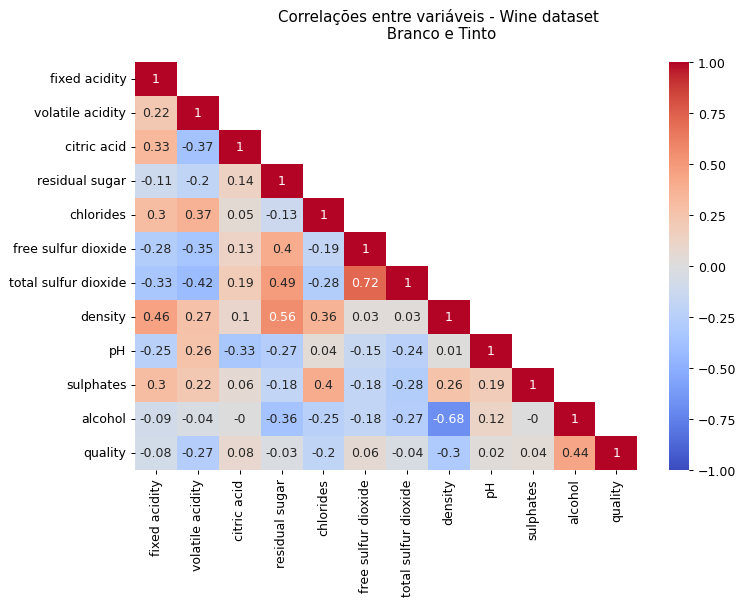

In [ ]:
mask = np.zeros_like(df_raw.iloc[:, :12].corr())
mask[np.triu_indices_from(mask, k = 1)] = True

plt.figure(figsize=(9, 6), dpi= 90)
g = sns.heatmap(df_raw.iloc[:, :12].corr().round(2),
                annot=True, center=0, vmin=-1, vmax=1,
                cmap = "coolwarm", mask = mask)
plt.suptitle('Correlações entre variáveis - Wine dataset\n Branco e Tinto')

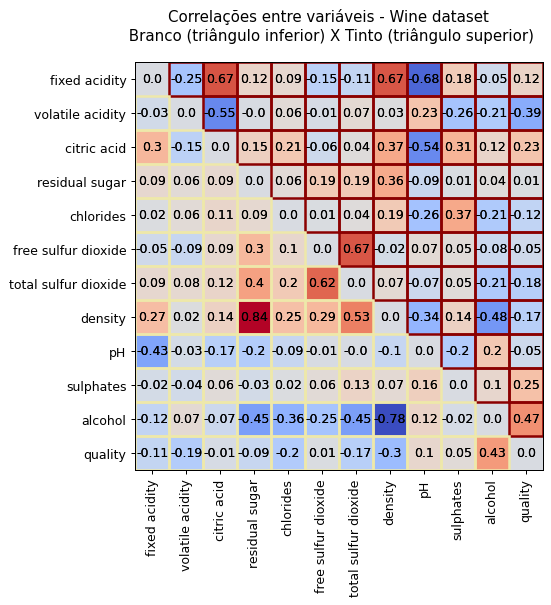

In [ ]:
#HEATMAP estratificado
colunas = df_raw.columns[:12]
## correlações por grupo
red_corr = df_raw[df_raw['type']=='red'].iloc[:, :12].corr()
red_corr = pd.DataFrame(np.triu(red_corr,k=1)) #red no upper triangle

white_corr = df_raw[df_raw['type']=='white'].iloc[:, :12].corr()
white_corr = pd.DataFrame(np.tril(white_corr,k=-1)) #white no lower triangle

## matriz correlações combinadas
combined_corr = red_corr + white_corr
combined_corr.columns = colunas
combined_corr = combined_corr.set_index(colunas)

# tratando dados para heatmap combinado
x = y = np.linspace(0,11, num=12)
X,Y = np.meshgrid(x,y)
isred = np.triu(np.ones((12,12), dtype=int),k=1)
iswhite = np.tril(np.ones((12,12), dtype=int),k=-1)

df_isred = pd.DataFrame({"y":Y.flatten(), "x":X.flatten(), "isred":isred.flatten()})
df_iswhite = pd.DataFrame({"y":Y.flatten(), "x":X.flatten(), "iswhite":iswhite.flatten()})

df_corr = pd.DataFrame({"y":Y.flatten(), "x":X.flatten(), "corr":combined_corr.to_numpy().flatten()})

# prepara Dataframes
df = df_corr.pivot(index="y", columns="x")
dfmarkR = df_isred[df_isred["isred"]>0]
dfmarkW = df_iswhite[df_iswhite["iswhite"]>0]

#plot
fig, ax=plt.subplots(figsize=(9, 6), dpi= 90)

x = df_corr["x"].unique()
y = df_corr["y"].unique()
ext = [x.min()-np.diff(x)[0]/2.,x.max()+np.diff(x)[0]/2., 
       y.max()+np.diff(y)[0]/2.,y.min()-np.diff(y)[0]/2. ] #invertida para ficar igual heatmap
ax.imshow(df, extent=ext, cmap = 'coolwarm')
for (j,i),label in np.ndenumerate(df):
    ax.text(i,j,label.round(2),ha='center',va='center')
    ax.text(i,j,label.round(2),ha='center',va='center')

ax.set_xticks(x, labels=colunas)
plt.xticks(rotation=90)
ax.set_yticks(y, labels=colunas)
plt.suptitle('Correlações entre variáveis - Wine dataset\n Branco (triângulo inferior) X Tinto (triângulo superior)')

dx = 1; dy = 1
for (xi,yi), in zip(dfmarkR[["x","y"]].values):
    rec = plt.Rectangle((xi-dx/2.,yi-dy/2.),dx,dy, fill=False,
                        edgecolor="darkred", lw=2 )
    ax.add_artist(rec)
for (xi,yi), in zip(dfmarkW[["x","y"]].values):
    rec = plt.Rectangle((xi-dx/2.,yi-dy/2.),dx,dy, fill=False,
                        edgecolor="palegoldenrod", lw=2 )
    ax.add_artist(rec)

## Boxplots

Considerando o objetivo de explicar o comportamento da variável `quality` com base no comportamento de outras variáveis, foi proposto um aprofundamento da análise estatística descritiva utilizando `boxplots` para as variáveis que estiveram mais correlacionadas com a variável resposta na análise global:
- `volatile acidity`
- `chlorides`
- `density`
- `alcohol`
Ainda para ilustrar o comportamento com cada um dos extratos dos dados, a análise preservou um enforque em caracaterizar também o comportamento de forma estratificada por tipo de vinho. 

A análise visual dos boxplots por tipo de vinho indica que `volatile acidity` e `chlorides` são variáveis com maior potencial para discriminar o tipo de vinho (boxsplots mais separados), potencialmente se comportantem de formas diferentes em cada extrato (seria necessária um teste $Chi^2$ de médias para confimar). Estas variáveis também apresentaram maior cauda (e alta ocorrência de outliers).  
Para a variável resposta, o boxplot indica os valores de nota 3, 8 e 9 como outliers. Optou-se por manter tais outliers, considerando a natureza discreta da variável e posteriores testes com algoritmos de regressão linear. Porém, esta análise preliminar já reforça o potencial para utilizar regressão logística (binomial ou múltipla) para prever a qualidade do vinho.

Text(0.5, 0.98, 'Boxplot de variáveis selecionadas (|corr(quality)| > 0.2) \n Wine dataset')

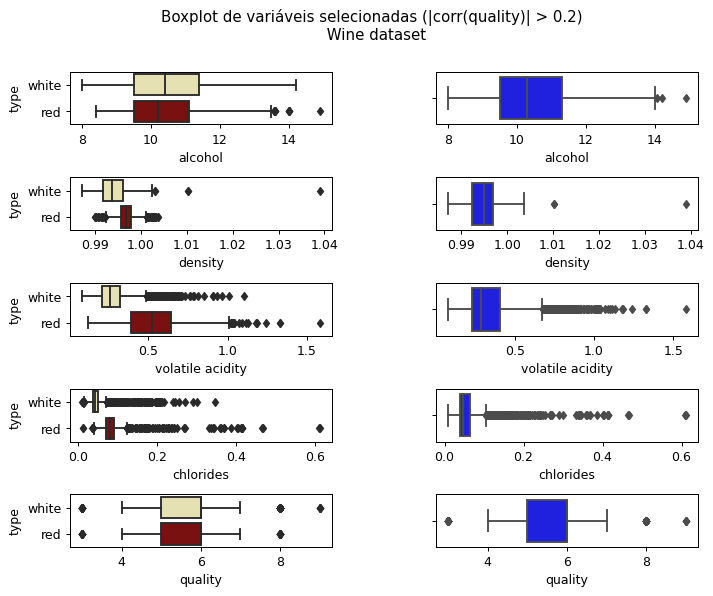

In [ ]:
# escolha de variáveis (corr >= 0.2)
slcted_vars = ['alcohol', 'density', 'volatile acidity', 'chlorides', 'quality', 'type']

# boxplots
fig = plt.figure(figsize=(9, 7), dpi= 90)
fig.subplots_adjust(hspace=1, wspace=0.4)
for i in range(0,5):
    ax = fig.add_subplot(5, 2, i*2+1)
    sns.boxplot(x=slcted_vars[i], y='type', data=df_raw, ax = ax, palette = cores)
    ax = fig.add_subplot(5, 2, i*2+2)
    sns.boxplot(x=slcted_vars[i], data=df_raw, ax = ax, color = 'blue')
fig.suptitle('Boxplot de variáveis selecionadas (|corr(quality)| > 0.2) \n Wine dataset')

A variável `density`apresenta baixa variabilidade entre as notas de qualidade, em ambos os extratos, conforme indicado nos gráficos de barra a seguir. Enquanto, `alcohol`, `chlorides` e `volatile acidity` apresentam maior variabilidade, indicando potenciais bons preditores para `quality`.

[(6.0, 14.0)]

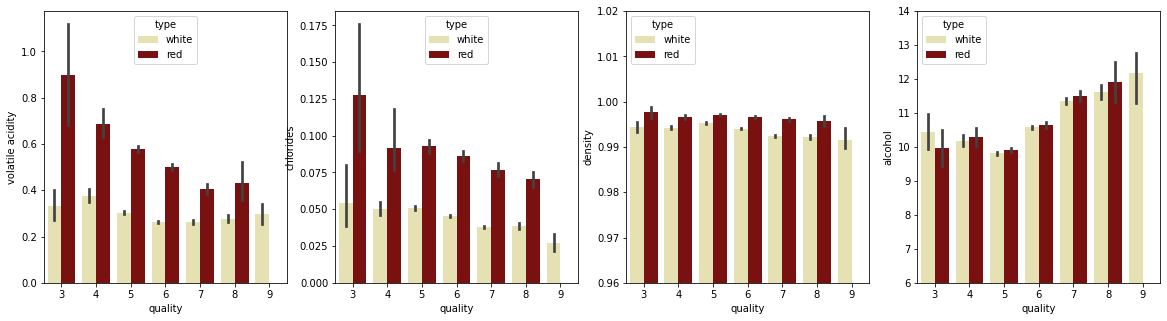

In [ ]:
f, axes = plt.subplots(1, 4)
f.set_figheight(5)
f.set_figwidth(20)
sns.barplot(x='quality', y='volatile acidity', data=df_raw, hue='type' , ax=axes[0],  palette = cores)
sns.barplot(x='quality', y='chlorides', data=df_raw, hue='type' , ax=axes[1],  palette = cores)
sns.barplot(x='quality', y='density', data=df_raw, hue='type' , ax=axes[2],  palette = cores)
axes[2].set(ylim=(0.96,1.02))
sns.barplot(x='quality', y='alcohol', data=df_raw, hue='type' , ax=axes[3],  palette = cores)
axes[3].set(ylim=(6,14))

Os comportamentos diferentes de acordo com o tipo de vinho despertam a curiosidade para uma caracterização mais detalhada do "sinal" de cada variável nas notas que definem a qualidade do vinho. Os plots do tipo violino são uma ferramenta poderosa para visualizar tais discrepâncias. Abaixo são apresentados os *violin plots* para as variáveis `alcohol` e `volatile acidity` de acordo com as notas de `quality` para cada tipo de vinho.  
A análise destas figuras reforça o achado preliminar de que a relação entre `alcohol` e `quality` não é tão diferente para vinhos de tipos diferentes. Já a relação entre `volatile acidity` e `quality` apresenta curvas consistentemente diferentes para vinhos do tipo tinto/red e branco/white. Considerando que os vinhos do tipo branco/white, a variável pode servir para diferenciar os vinhos com notas muito baixas 3 e 4. Para vinhos tinto/red, `quality` varia de forma linear, com melhores notas tribuídas a vinhos com menores valores de `volatile acidity`. 

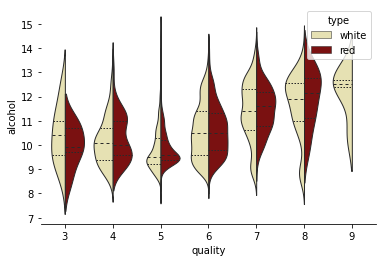

In [ ]:
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=df_raw, x="quality", y="alcohol", hue="type",
               split=True, inner="quart", linewidth=1,  palette = cores)
sns.despine(left=True)

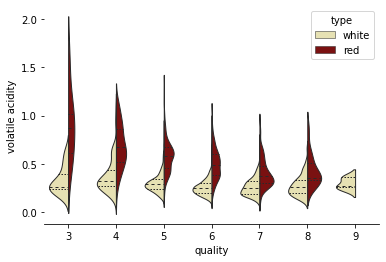

In [ ]:
sns.violinplot(data=df_raw, x="quality", y="volatile acidity", hue="type",
               split=True, inner="quart", linewidth=1,  palette = cores)
sns.despine(left=True)

A EDA evidenciou potenciais associações entre variáveis que poderão ser exploradas através de técnicas de regressão. A partir de correlações lineares de Pearson, existe um indicativo de que quatro variáveis principais influenciam majoritariamente o comportamento da variável resposta de interesse (`volatile acidity`, `chlorides`, `density`, `alcohol`). 
Contudo, é importante destacar a forte correlação entre algumas dessas variáveis, como `density` e `alcohol`. A multicolineariedade prejudica a robustez dos resultados de técnicas como a de regressão linear. Assim, é importante testar diferentes combinações de variáveis explicativas e estar atento às premissas de validade de cada método.  

Antes de avançar para a etapa de Regressão Linear, registramos o *pairplot* das variáveis mais exploradas até aqui como um resumo geral, reforçando potenciais diferenças entre os extratos. 

Text(0.5, 1.05, 'PairPlot - Wine Dataset (variáveis de destaque)')

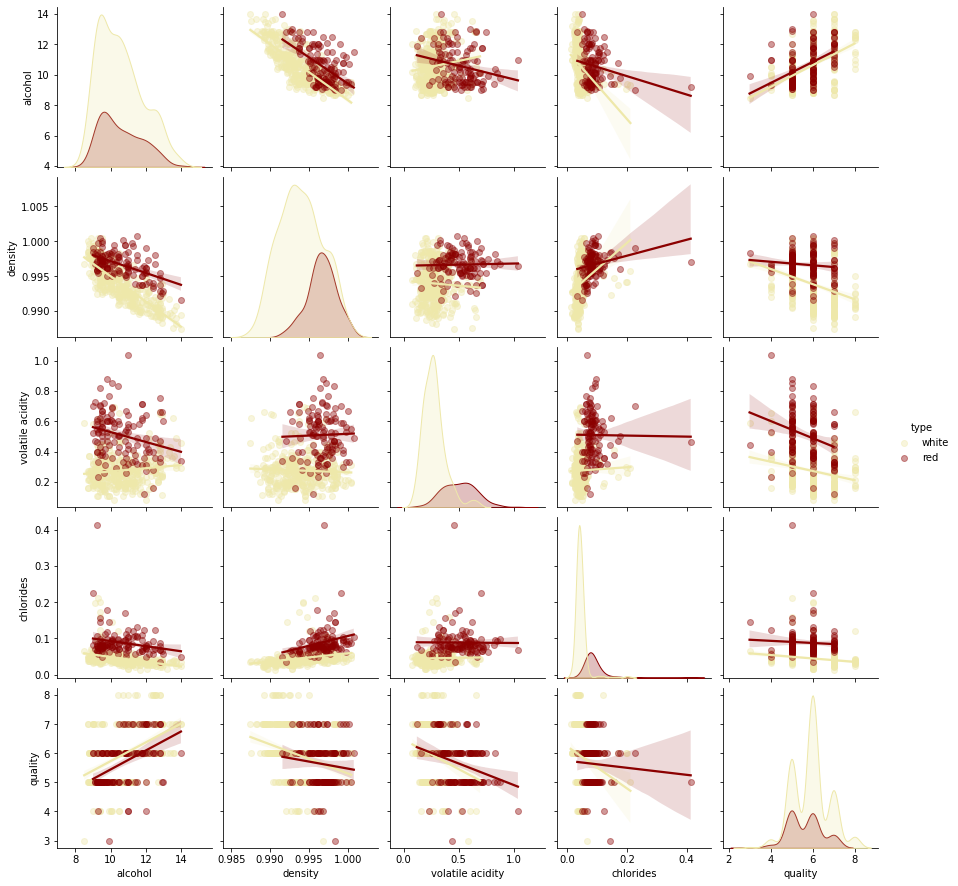

In [ ]:
# pairplot
# escolha de variáveis (corr >= 0.2)
slcted_vars = ['alcohol', 'density', 'volatile acidity', 'chlorides', 'quality', 'type']
sns.pairplot(df_raw[slcted_vars].sample(500), hue='type', palette = cores, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.4}})
fig.suptitle('PairPlot - Wine Dataset (variáveis de destaque)', y=1.05)


# Regressão Linear

### Highlights
> - Para uma análise inicial, foram desenvolvidos modelos univariados, dessa forma permitindo um entendimento de como as variavéis se relacionam individualmente com a variável resposta qualidade.
> - Uma vez feita essa análise, foram elaborados modelos multivariados que buscaram maximizar as métricas de $R^2$ e $R^2 ajustado$ e minimizar o $RMSE$. Devido à variabilidade que $R^2$ apresentou com uso de muitas variáveis, escolhemos fazer o benchmark de diferentes modelos por meio da métrica de $RMSE$.  
> - O melhor modelo escolhido (Modelo Quintella) utilizou as variavéis `volatile acidity`, `residual sugar`, `sulphates`, `alcohol`, `density`, `chlorides` e `total sulfur dioxide` em combinações diferentes para vinhos tinto/red e branco/white, atingindo $RMSE$ = 0.759. Contudo, seu desempenho não foi o ideal a medida que as premissas de validade da regressão linear não foram garantidas.
> - Concluimos que para o dataset em questão a escolha do modelo de regressão linear não seja a melhor escolha, talvez para o futuro a utilização de modelos de classificacção possa ser estudada.

## Procedimento para parametrização da regressão
O dataset "Wine Quality" é divido em dois arquivos, um referente a vinhos tintos e outro a vinhos brancos. Para o desenvolvimento dos modelos de regressão unificamos os datasets em um, ignorando as diferenças entre os tipos de vinhos que foram observadas no etapa de EDA.  
Tendo o dataset completo, `df_raw`, selecionamos métricas condizentes para a análise de desempenho dos modelos. Seguindo as práticas comuns de avaliação de modelos de regressão linear, adotamos as métricas de $R^2$, $RMSE$ e $R^2 ajustado$ para podermos comparar os diferentes modelos desenvolvidos.  
Os primeiros modelos desenvolvidos foram univariados, permitindo a construção de hipóteses que foram utilizadas na construção de modelos multivariados. Uma vez que a utilização de muitas variavéis pode influenciar os resultados $R^2$, adotamos a $RMSE$ como medida principal de comparação dos modelos. A avaliação dos modelos foi organizada através de uma classe específica (`class RegEval`) - descrita na sessão Métrica e avaliação.  
Com base na avaliação dos modelos, foi escolhido o modelo com melhor performance e apresentada uma análise expandida focada na confirmação do pressuposto de normalidade dos resíduos. Esta análise permitiu um aprofundamento sobre a  validade do modelo e potenciais alternativas.

## Métrica e avaliação

Nesta sessão definimos a classe que sumariza as métricas para avaliação dos modelos de regressão linear.

In [ ]:
from sklearn import metrics
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import shapiro

class RegEval:
  """
  Exemplo de uso:
  reg_eval = RegEval(X_test, y_test, y_pred)
  """
  def __init__(self, X_test, y_test, y_pred, do_print=False, do_plot=False):
    self.X_test = X_test
    self.y_test = y_test
    self.y_pred = y_pred

    residuals = y_test-y_pred
    self.residuals = residuals
    self.std_residuals = (residuals - residuals.mean())/residuals.std()

    self.results = {
        'R2': metrics.r2_score(y_test, y_pred),
        'R2adjst': 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_pred)-1)/(len(y_pred)-X_test.shape[1]-1),
        'RMSE': metrics.mean_squared_error(y_test, y_pred, squared=False),
        'PSHAPIRO': shapiro(residuals).pvalue
        }

    if do_print: print(self)
    if do_plot: self.plot()

  def __str__(self):
     rep = f"R2:  {self.results['R2'].round(3)} \n"
     rep += f"R2adjst:  {self.results['R2adjst'].round(3)} \n"
     rep += f"RMSE:  {self.results['RMSE'].round(3)} \n"
     rep += f"PSHAPIRO:  {self.results['PSHAPIRO']:.2E} \n"
     return rep


  def plot(self):
    fig = plt.figure(figsize=(16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(2, 2, 1)
    sns.histplot(data = self.std_residuals, kde = True, stat = "density", label='samples')
    # calculate the pdf
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = norm.pdf(x_pdf)
    ax.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')                                                   
    ax.legend()
    plt.title("Residuals")


    ax = fig.add_subplot(2, 2, 2)
    plt.scatter(y_pred, self.std_residuals, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title("Residuals")

    ax = fig.add_subplot(2, 2, 3)
    probplot(self.std_residuals[:,0], plot = ax, fit=True)


    ax = fig.add_subplot(2, 2, 4)
    # Vamos criar um gráfico para comparar os Valores Reais com os Preditos
    l = plt.plot(self.y_pred, self.y_test, 'bo', alpha=0.1)
    plt.setp(l, markersize=10)
    plt.setp(l, markerfacecolor='C0')
    plt.title('Comparação Valor Predito x Valor Real', fontsize=12)
    plt.ylabel("True Value", fontsize=12)
    plt.xlabel("Predict Value", fontsize=12)
    # mostra os valores preditos e originais
    xl = np.arange(min(self.y_test), 1.2*max(self.y_test),(max(self.y_test)-min(self.y_test))/10)
    yl = xl
    plt.plot(xl, yl, 'r--')

    plt.show();

## Modelagem e predição

### Modelos Univariados
Assim como a análise de correlações foi a primeira abordagem para avaliar as potenciais associações entre variáveis no processo de EDA, para o processo de regressão linear foram definidos inicialmente modelos univariados, buscando-se avaliar a influência de cada uma das variáveis explicativas (11 colunas originais de dados quantitativos da base de dados) na variável resposta. Para esta análise foi proposta um partição da base de dados em base *Treino* e *Validação* (70/30)   
Os dados foram padronizados com base no preprocessador `StandardScaler`. O módulo de regressão linear do `Scikit-Learn` foi utilizado, e assim não foram avaliadas significâncias estatísticas de cada parâmetro calculado para os modelos. A avaliação da qualidade de cada modelo foi avaliada a partir do *p-value* do teste de *Shapiro-Wilk* para julgar a normalidade dos resíduos. A qualidade dos modelos foi avaliada com base nas métricas descritas anteriormente (foco em minimizar $RMSE$).

In [ ]:
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LinearRegression

#splittou e padronizou
train_size = 0.7

X = df_raw.drop(['quality', 'type', 'ID', 'is_good'], axis = 1)
y = df_raw['quality']

# In the first step we will split the data in training and remaining dataset
X_train, X_validation, y_train, y_validation = train_test_split(X,y, train_size=train_size, random_state=42)

X_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_validation = X_scaler.transform(X_validation)

df_features = pd.DataFrame()
for i in range(0,len(X.columns)):
# Instancia o modelo
    linreg = LinearRegression()
    # Fit dos dados (ou seja, vamos passar os dados para o modelo aprender com eles)
    linreg.fit(X_train[:,i].reshape(-1, 1), y_train)
    # Para os dados novos, vamos definir a predição para a base de teste
    y_pred = linreg.predict(X_validation[:,i].reshape(-1, 1)) 
    reg_eval = RegEval(X_validation, y_validation, y_pred)
    df_features = df_features.append(pd.Series(reg_eval.results, name=X.columns[i]))

df_features.sort_values('RMSE', ascending=True)
print(df_features)
df_features['Features'] = df_features.index

                          PSHAPIRO        R2   R2adjst      RMSE
fixed acidity         8.066700e-29  0.005552 -0.000724  0.899464
volatile acidity      6.613597e-18  0.062996  0.057082  0.873100
citric acid           2.020700e-27  0.002227 -0.004070  0.900967
residual sugar        6.646027e-31 -0.001513 -0.007833  0.902654
chlorides             6.144593e-25  0.033504  0.027404  0.886733
free sulfur dioxide   3.213528e-30  0.004218 -0.002067  0.900068
total sulfur dioxide  8.214253e-31 -0.000305 -0.006618  0.902110
density               2.285350e-10  0.085004  0.079229  0.862785
pH                    2.090120e-31 -0.002035 -0.008359  0.902889
sulphates             4.970795e-32  0.001467 -0.004835  0.901310
alcohol               7.904939e-15  0.190883  0.185777  0.811332


Os resultados dos modelos univariado refletiram os achados sobre correlação explorados na sessão de EDA. `alcohol`, `density`, `volatile acidity` e `chlorides` foram as variávéis cujos modelos univariados performaram melhor, com menores valores de $RMSE$.  
Contudo, em nenhum dos casos foi possível validar o modelo de regressão linear, uma vez que a premissa de normalidade dos resíduos foi descartada (hipótese nula rejeitada em *Shapiro-Wilk*).

### Modelos Multivariados  
Após a análise de modelos univariados, foram propostos modelos multivariados. Sem abordar potenciais combinações de variáveis que explorem relações polinomiais, com maiores graus para os recursos baseados nas variáveis explicativas ($x$, $x^2$, $x^3$ etc), apenas combinações das variáveis originais foram testadas como modelos multivariados. Não foram testadas interações entre estas features.  
Apresentamos aqui alguns dos modelos para ilustrar a variedade de resultados. Com base nas métricas de avaliação o *Modelo Quintella* apresentou menor $RMSE$.

In [ ]:
X = df_raw.drop(['quality', 'type', 'ID', 'is_good', 'fixed acidity', 'pH', 'chlorides', 'citric acid'], axis = 1)
y = df_raw['quality']

# In the first step we will split the data in training and remaining dataset
X_train, X_validation, y_train, y_validation = train_test_split(X,y, train_size=0.7, random_state=42)

X_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_validation = X_scaler.transform(X_validation)

# Instancia o modelo
linreg_henrique = LinearRegression()
# Fit dos dados (ou seja, vamos passar os dados para o modelo aprender com eles)
linreg_henrique.fit(X_train, y_train)
# Para os dados novos, vamos definir a predição para a base de teste
y_pred = linreg_henrique.predict(X_validation)

eval_henrique = RegEval(X_validation, y_validation, y_pred)

resultados_linear_henrique = pd.Series(eval_henrique.results, name='Modelo Henrique')
resultados_linear_henrique['Features'] = list(X.columns)
resultados_linear_henrique

R2                                                   0.280898
R2adjst                                              0.278017
RMSE                                                 0.764871
PSHAPIRO                                                  0.0
Features    [volatile acidity, residual sugar, free sulfur...
Name: Modelo Henrique, dtype: object

In [ ]:
X = df_raw.drop(['density', 'fixed acidity', 'chlorides', 'pH', 'quality', 'type', 'ID', 'is_good'], axis = 1) #stepwise no R
y = df_raw['quality']

# In the first step we will split the data in training and remaining dataset
X_train, X_validation, y_train, y_validation = train_test_split(X,y, train_size=0.7, random_state=42)

X_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_validation = X_scaler.transform(X_validation)

# Instancia o modelo
linreg_samya = LinearRegression()
# Fit dos dados (ou seja, vamos passar os dados para o modelo aprender com eles)
linreg_samya.fit(X_train, y_train)
# Para os dados novos, vamos definir a predição para a base de teste
y_pred = linreg_samya.predict(X_validation)

eval_samya = RegEval(X_validation, y_validation, y_pred)

resultados_linear_samya = pd.Series(eval_samya.results, name='Modelo Samya')
resultados_linear_samya['Features'] = list(X.columns)
resultados_linear_samya

R2                                                   0.281302
R2adjst                                              0.278423
RMSE                                                 0.764656
PSHAPIRO                                                  0.0
Features    [volatile acidity, citric acid, residual sugar...
Name: Modelo Samya, dtype: object

In [ ]:
# Classe de multimodelos Quintella
from sklearn.preprocessing import  StandardScaler

class MultiModelo:
  def __init__(self, modelo, cols_white, cols_red):
    self.cols_white = cols_white
    self.cols_red = cols_red
    self.linreg_white = modelo()
    self.linreg_red = modelo()
    self.X_scaler_white = StandardScaler()
    self.X_scaler_red = StandardScaler()

  def fit(self, X_train, y_train):
    is_white_train = X_train['is_white']==1

    # Treino: Separar dados por tipo de vinho e selecionar variaveis utilizadas
    X_train_white = X_train[is_white_train].loc[:, self.cols_white].values
    X_train_red = X_train[~is_white_train].loc[:, self.cols_red].values
    y_train_white = y_train[is_white_train].values
    y_train_red = y_train[~is_white_train].values

    # Instanciar e Treinar modelos
    X_train_white = self.X_scaler_white.fit_transform(X_train_white)
    X_train_red = self.X_scaler_red.fit_transform(X_train_red)
    self.linreg_white.fit(X_train_white, y_train_white)
    self.linreg_red.fit(X_train_red, y_train_red)
    X_scaler_white = StandardScaler()
    X_train_white = X_train[is_white_train].drop(columns= 'is_white')
    cols = X_train_white.columns
    X_train_white = X_scaler_white.fit_transform(X_train_white)

  def predict(self, X_validation):
    self.is_white_validation = X_validation['is_white']==1

    # Validacao: Separar dados por tipo de vinho e selecionar variaveis utilizadas
    X_validation_white = X_validation[self.is_white_validation].loc[:, self.cols_white].values
    X_validation_red = X_validation[~self.is_white_validation].loc[:, self.cols_red].values

    # Predict com base em variáveis de validacao.
    X_validation_white = self.X_scaler_white.transform(X_validation_white)
    X_validation_red = self.X_scaler_red.transform(X_validation_red)
    y_pred_white = self.linreg_white.predict(X_validation_white)
    y_pred_red = self.linreg_red.predict(X_validation_red)
    y_pred = np.concatenate([y_pred_white, y_pred_red], axis=0) 
    
    return y_pred

  def reorder_validation(self, X_validation, y_validation):
    """
    Reordena dados y_validadtion para mesma ordem utilizada no y_pred. 
    Retorna X_validation na mesma ordem e apenas colunas utilizadas.
    FutureWork: 
    - Remover essa função: reordenar y_pred para ordem original no termino de self.predict.
    - Remover essa função: definir X_validation como atributo definido no self.fit.
    """
    X_validation = X_validation.loc[:,list(set(cols_white + cols_red))].values
    y_validation_white = y_validation[self.is_white_validation].values
    y_validation_red = y_validation[~self.is_white_validation].values
    y_validation = np.concatenate([y_validation_white, y_validation_red], axis=0)
    return X_validation, y_validation

In [ ]:
#Modelo Linear Quintella
from sklearn.linear_model import LinearRegression

df = df_raw.copy()
df['is_white'] = df['type'].apply(lambda x : 1 if x =='white' else 0)
X = df.drop(['quality', 'is_good', 'type', 'ID'], axis = 1)
y = df.loc[:,['quality']]

# In the first step we will split the data in training and remaining dataset
X_train, X_validation, y_train, y_validation = train_test_split(X,y, train_size=0.7, random_state=42)

cols_white = ['alcohol', 'volatile acidity', 'sulphates', 'residual sugar', 'density', 'pH'] # Backward 6
cols_red = ['alcohol', 'volatile acidity', 'sulphates', 'chlorides', 'total sulfur dioxide']# Backward 5

quintella_reglin = MultiModelo(LinearRegression, cols_white, cols_red) 
quintella_reglin.fit(X_train, y_train)
y_pred = quintella_reglin.predict(X_validation)

X_validation, y_validation = quintella_reglin.reorder_validation(X_validation, y_validation)

# Avaliacao de modelo
eval_quintella = RegEval(X_validation, y_validation, y_pred)

resultados_linear_quintella = pd.Series(eval_quintella.results, name='Modelo Quintella')
resultados_linear_quintella['Features'] = list(set(cols_white + cols_red))
resultados_linear_quintella

R2                                                   0.291655
R2adjst                                              0.288409
RMSE                                                 0.759129
PSHAPIRO                                                  0.0
Features    [chlorides, alcohol, sulphates, total sulfur d...
Name: Modelo Quintella, dtype: object

### Resultados e discussão

O dataframe `resultados_linear` apresenta o resultado dos modelos multivariados apresentados e o melhor modelo univariado para análise comparativa das métricas. O melhor modelo foi o *Modelo Quintella*, que conseguiu menor valor de *RMSE*, e maior valor de $R^2 ajustado$.  
Este modelo considera modelos específicos para tipo de vinho, e era esperada a melhor performance a partir da análise apresentada na EDA: algumas variáveis apresentavam comportamento distintos em cada extrato. As variáveis envolvidas são `volatile acidity`, `residual sugar`, `sulphates`, `alcohol`, `density`, `chlorides` e `total sulfur dioxide` em combinações diferentes para vinhos tinto/red (5 variáveis) e branco/white (6 variáveis), atingindo $RMSE$ = 0.759.  
Entretanto, a validade de um modelo linear está condicionada a algumas premissas, incluindo normalidade dos resíduos. Para esta análise, foi executado um teste de *Shapiro-Wilk* nos resíduos de cada um dos modelos, sendo a hipótese nula = normalidade. Em todos os modelos a hipótese nula é rejeitada, portanto a normalidade dos resíduos não é garantida, nem no modelo escolhido.

In [ ]:
resultados_linear = pd.DataFrame()
resultados_linear = resultados_linear.append(resultados_linear_henrique)
resultados_linear = resultados_linear.append(resultados_linear_samya)
resultados_linear = resultados_linear.append(resultados_linear_quintella)
resultados_linear = resultados_linear.append(df_features.iloc[0,:])
resultados_linear = resultados_linear.sort_values('RMSE', ascending=True)
display(resultados_linear[['RMSE', 'R2', 'R2adjst', 'PSHAPIRO', 'Features']])

,RMSE,R2,R2adjst,PSHAPIRO,Features
Modelo Quintella,0.759129,0.291655,0.288409,2.080004e-11,"[chlorides, alcohol, sulphates, total sulfur d..."
Modelo Samya,0.764656,0.281302,0.278423,2.632818e-12,"[volatile acidity, citric acid, residual sugar..."
Modelo Henrique,0.764871,0.280898,0.278017,2.490112e-12,"[volatile acidity, residual sugar, free sulfur..."
fixed acidity,0.899464,0.005552,-0.000724,8.066700e-29,fixed acidity


O melhor modelo escolhido, apesar de apresentar melhores métricas de avaliação comparativamente aos outros modelos testados, considera variáveis altamente correlacionadas (`alcohol` e `densidade`, por exemplo). Isto significa que há multicolineariedade entre variáveis explicativas, prejudicando a performance e validade do modelo.  
Sendo assim, concluímos que a abordagem baseada em regressão linear não explica de forma satisfatória o comportamento da variável `quality`, uma vez que pode ser considerada categórica. Essa característica dificulta a garantia de normalidade de resíduos. 

# Regressão Logística

### Highlights  
> - Para uma análise via regressão logística, foi criada uma variável categórica binária `is_good` a partir da nota: `quality` >= 5 foi utlizada para classificação *BOM* (valor 1); `quality` < 5 para classe *Não BOM*, aka *RUIM* (valor 0).  
> - Foram desenvolvidos modelos univariados, dessa forma permitindo um entendimento de como as variavéis se relacionam individualmente com a probabilidade de classificação entre vinho bom e ruim.
> - Uma vez feita essa análise, foram elaborados modelos multivariados que buscaram maximizar as métricas de $acurácia$, $precisão$ e $recall/sensitividade$. Para simplificar a avaliação dos resultados, escolhemos fazer o benchmark de diferentes modelos por meio da métrica de $F1-Score$, que busca balancear $precisão$ e $recall$.  
> - O melhor modelo escolhido (Modelo Quintella) utilizou as variavéis `volatile acidity`, `residual sugar`, `free sulfur dioxide`, `alcohol` e `total sulfur dioxide` em combinações diferentes para vinhos tinto/red e branco/white. O modelo alcançou um $F1-Score$ = 80.4%.  
> - Concluimos que para o dataset em questão a utilização de abordagens de classificação são mais indicadas. Contudo, a análise de diferentes thresholds de corte (*cut-offs*) pode ser válida para aprimorar o modelo.

## Procedimento para parametrização da regressão

Para a análise com base em regressão logística foi mantida a estrutura unificada do dataset "Wine Quality", referentes a vinhos tintos e outro a vinhos brancos.   
Tendo o dataset completo, `df_raw`, selecionamos métricas condizentes para a análise de desempenho dos modelos. Seguindo as práticas comuns de avaliação de modelos de regressão logística, adotamos as métricas de $accurácia$, $precisão$ e $recall/sensitividade$ para podermos comparar os diferentes modelos desenvolvidos.  
Os primeiros modelos desenvolvidos foram univariados, permitindo a construção de hipóteses que foram utilizadas na construção de modelos multivariados. Uma vez que a utilização de muitas variavéis pode influenciar de forma diferente os resultados de $precisão$ e $recall$, adotamos o $F1-Score$ como medida principal de comparação dos modelos. A avaliação dos modelos foi organizada através de um dataframe (`resultados_logisticos`).  
Com base na avaliação dos modelos, foi escolhido o modelo com melhor performance para posteriormente ser testado na base de dados *TESTE*.

## Modelagem e Predição

### Modelos Univariados
Assim como a análise de regressão linear, para o processo de regressão logística foram definidos inicialmente modelos univariados, buscando-se avaliar a influência de cada uma das variáveis explicativas (11 colunas originais de dados quantitativos da base de dados) na variável resposta (`is_good`). Para esta análise foi proposta um partição da base de dados em base *Treino* e *Validação* (70/30)   
Os dados foram padronizados com base no preprocessador `StandardScaler`. O módulo de regressão logística do `Scikit-Learn` foi utilizado, e assim não foram avaliadas significâncias estatísticas de cada parâmetro calculado para os modelos. A avaliação da qualidade de cada modelo foi avaliada a partir das métricas já indicadas para análise de algoritmos de classificação, focando na classificação de casos *POSITIVOS*, i.e. vinhos bons (`is_good` = 1) - hehe.

In [ ]:
X = df_raw.drop(['quality', 'type', 'ID', 'is_good'], axis = 1)
y = df_raw['is_good']
# In the first step we will split the data in training and remaining dataset
X_train, X_validation, y_train, y_validation = train_test_split(X,y, train_size=0.7, random_state=42)

X_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_validation = X_scaler.transform(X_validation)

df_features = pd.DataFrame()
for i in range(0,len(X.columns)):
# Instancia o modelo
    classifier = LogisticRegression(random_state=42)
    # Fit dos dados (ou seja, vamos passar os dados para o modelo aprender com eles)
    classifier.fit(X_train[:,i].reshape(-1, 1), y_train.values)
    # Para os dados novos, vamos definir a predição para a base de teste
    y_pred = classifier.predict(X_validation[:,i].reshape(-1, 1))
    logit_results = {
        'F1-Score': metrics.f1_score(y_validation, y_pred),
        'Accuracy': metrics.accuracy_score(y_validation, y_pred),
        'Precision': metrics.precision_score(y_validation, y_pred),
        'Recall': metrics.recall_score(y_validation, y_pred),
        'Features': [X.columns[i]]
        }

    df_features = df_features.append(pd.Series(logit_results, name=X.columns[i]))

df_features = df_features.sort_values('F1-Score', ascending=False)
print(df_features.drop(columns = 'Features').round(3))

                      Accuracy  F1-Score  Precision  Recall
volatile acidity         0.658     0.769      0.664   0.913
citric acid              0.622     0.767      0.622   1.000
residual sugar           0.622     0.767      0.622   1.000
free sulfur dioxide      0.622     0.767      0.622   1.000
total sulfur dioxide     0.622     0.767      0.622   1.000
pH                       0.622     0.767      0.622   1.000
sulphates                0.622     0.767      0.622   1.000
fixed acidity            0.620     0.765      0.621   0.995
chlorides                0.624     0.762      0.628   0.968
alcohol                  0.679     0.754      0.721   0.790
density                  0.617     0.736      0.644   0.858


Muitos dos modelos univariados apresentaram tendência de inflar a classificação de casos *POSITIVOS* ($recall = 1$), indicando que suas variáveis explicativas basicamente não eram efetivas para diferenciar a classe univariavelmente. ESte foi o caso para os modelos utilizando: `citric acid`, `residual sugar`, `free sulfur dioxide`, `total sulfur dioxide`, `pH` e `sulphates`. 
As variáveis que demonstraram algum poder preditivo são variáveis indicadas como mais correlacionadas com a variável `quality`, conforme apresentado na EDA. A variável `volatile acidity` apresentou a segunda melhor precisão e acurácia, e obteve melhor F1-score.

### Modelos Multivariados

Após a análise de modelos univariados, foram propostos modelos multivariados. Sem abordar potenciais combinações de variáveis que explorem relações polinomiais, com maiores graus para os recursos baseados nas variáveis explicativas ($x$, $x^2$, $x^3$ etc), apenas combinações das variáveis originais foram testadas como modelos multivariados. Não foram testadas interações entre estas features.  
Apresentamos aqui alguns dos modelos para ilustrar a variedade de resultados. Com base nas métricas de avaliação o *Modelo Quintella* apresentou melhor performance.

In [ ]:
features = ['alcohol', 'volatile acidity', 'residual sugar','total sulfur dioxide']
X = df_raw[features]
y = df_raw['is_good']
# In the first step we will split the data in training and remaining dataset
X_train, X_validation, y_train, y_validation = train_test_split(X,y, train_size=0.7, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validation = sc.transform(X_validation)

classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_validation)
# print(metrics.classification_report(y_validation, y_pred))

resultados = {'F1-Score': metrics.f1_score(y_validation, y_pred),
'Accuracy': metrics.accuracy_score(y_validation, y_pred),
'Precision': metrics.precision_score(y_validation, y_pred),
'Recall': metrics.recall_score(y_validation, y_pred),
'Features': features}

resultados_henrique = pd.Series(resultados, name='Modelo Henrique')
print(resultados_henrique)

F1-Score                                              0.791883
Accuracy                                              0.725356
Precision                                             0.748571
Recall                                                0.840513
Features     [alcohol, volatile acidity, residual sugar, to...
Name: Modelo Henrique, dtype: object


In [ ]:
# Modelo logistico Quintella
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

df = df_raw.copy()
df['is_white'] = df['type'].apply(lambda x : 1 if x =='white' else 0)
X = df.drop(['quality', 'is_good', 'type', 'ID'], axis = 1)
y = df.loc[:,['is_good']]

# In the first step we will split the data in training and remaining dataset
X_train, X_validation, y_train, y_validation = train_test_split(X,y, train_size=0.7, random_state=42)

cols_white = ['volatile acidity', 'residual sugar', 'free sulfur dioxide', 'alcohol'] #Backward 4
cols_red = ['volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol'] #Backward 4


quintella_reglog = MultiModelo(LogisticRegression, cols_white, cols_red) 
quintella_reglog.fit(X_train, y_train)
y_pred = quintella_reglog.predict(X_validation)

X_validation, y_validation = quintella_reglog.reorder_validation(X_validation, y_validation)

resultados = {'F1-Score': metrics.f1_score(y_validation, y_pred),
'Accuracy': metrics.accuracy_score(y_validation, y_pred),
'Precision': metrics.precision_score(y_validation, y_pred),
'Recall': metrics.recall_score(y_validation, y_pred),
'Features': list(set(cols_white + cols_red))}

resultados_quintella = pd.Series(resultados, name='Modelo Quintella')
resultados_quintella

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1-Score                                              0.804489
Accuracy                                               0.74188
Precision                                             0.760196
Recall                                                0.854262
Features     [free sulfur dioxide, alcohol, total sulfur di...
Name: Modelo Quintella, dtype: object

### Resultados e discussão
O dataframe `resultados_logistico` apresenta o resultado dos modelos multivariados apresentados e o melhor modelo univariado para análise comparativa das métricas considerando a abordagem logísitca. O melhor modelo foi o *Modelo Quintella*, que conseguiu maior valor de *F1-Score*, balanceando recall e precisão.  
Este modelo considera modelos específicos para tipo de vinho, e era esperada a melhor performance a partir da análise apresentada na EDA: algumas variáveis apresentavam comportamento distintos em cada extrato. As variáveis envolvidas são `volatile acidity`, `residual sugar`, `alcohol`, `free sulfur dioxide` e `total sulfur dioxide` em combinações diferentes para vinhos tinto/red (5 variáveis) e branco/white (6 variáveis), atingindo $F1-Score$ = 0.804. O modelo escolhido também apresenta melhor acurácia entre os modelos multivariados.

In [ ]:
resultados_logistico = pd.DataFrame()
resultados_logistico = resultados_logistico.append(resultados_henrique)
resultados_logistico = resultados_logistico.append(resultados_quintella)
resultados_logistico = resultados_logistico.append(df_features.iloc[0,:])
resultados_logistico = resultados_logistico.sort_values('F1-Score', ascending=False)
display(resultados_logistico.round(3)[['F1-Score', 'Accuracy', 'Precision', 'Recall', 'Features']])

,F1-Score,Accuracy,Precision,Recall,Features
Modelo Quintella,0.804,0.742,0.760,0.854,"[free sulfur dioxide, alcohol, total sulfur di..."
Modelo Henrique,0.792,0.725,0.749,0.841,"[alcohol, volatile acidity, residual sugar, to..."
volatile acidity,0.769,0.658,0.664,0.913,[volatile acidity]


O melhor modelo escolhido,que apresenta melhores métricas de avaliação comparativamente aos outros modelos testados, apresentou o melhor equilíbrio entre precisão e recall. Dentre as variáveis, temos inclusive a variável do melhor modelo univariado.  
Contudo, não foram testados diferentes limiares de threshold para o corte da probabilidade. Esta manipulação, não explorada aqui, pode melhorar a performance do modelo, direcionando para o objetivo principal de classificação que é acertar os *Casos POSITIVOS*, afinal, queremos que os vinhos bons sejam efetivamente caracterizados sem inflar a classificação de *POSITIVOS*.   

# Desempenho de Teste dos modelos selecionados

Finalmente, após as etapas de treino e ajuste dos modelos de regressão linear e logística, retomamos a base de dados de treino separada inicialmente para reportar a performance dos modelos escolhidos em cada uma das abordagens. Nesta etapa, além da análise de métricas já apresentada, aprofundamos a análise de performance com alguns elementos gráficos:
- Análise de plots para resíduos na **Regressão Linear**
- Matriz de confusão para resultado da **Regressão Logística**

## Linear
Aplicando o modelo `quintella_reglin` na base `X_test`. Modelo apresentou $RMSE = 0.724$. A análise de resíduos indica não normalidade, assim como o teste de *Shapiro-Wilk*. Ao plotar o gráfico de *valores preditos x valores reais* fica evidente a natureza discreta da variável resposta, bem como maior quantidade de observações com nota >= 5.

R2:  0.324 
R2adjst:  0.315 
RMSE:  0.724 
PSHAPIRO:  2.25E-04 



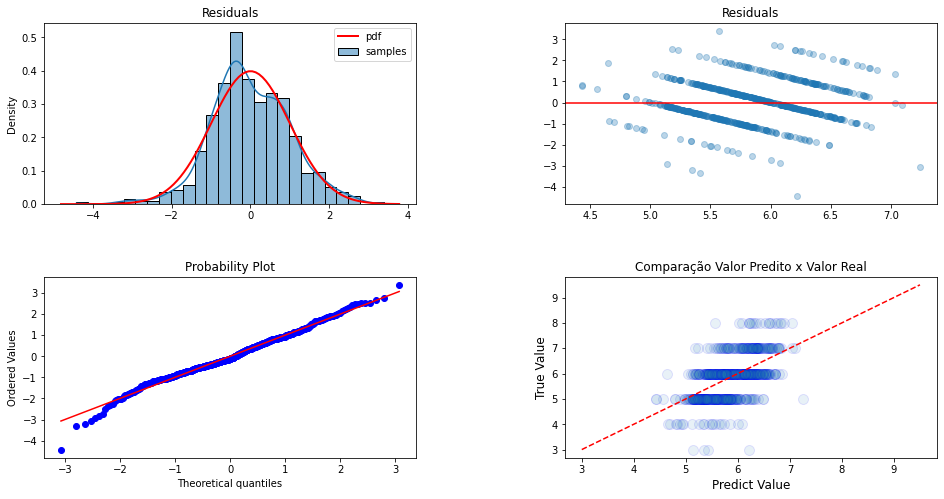

In [ ]:
df = df_test.copy()
df['is_white'] = df['type'].apply(lambda x : 1 if x =='white' else 0)
X_test = df.drop(['quality', 'is_good', 'type', 'ID'], axis = 1)
y_test = df.loc[:,['quality']]

y_pred = quintella_reglin.predict(X_test)

X_test, y_test = quintella_reglin.reorder_validation(X_test, y_test)

# Avaliacao de modelo
eval_final = RegEval(X_test, y_test, y_pred)
print(eval_final)
eval_final.plot()

## Logistico
Aplicando o modelo `quintella_reglog` na base `X_test`. Modelo apresentou $F1-Score = 0.808$ e $acurácia$ = 74.1%. Do ponto de vista do objetivo de identificar de forma correta os vinhos bons, o modelo classificou como *Falso POSITIVOS* apenas 9% das ocorrências, atingindo uma precisão mais elevada que no datset de treino/validação.

In [ ]:
# Modelo logistico 
df = df_test.copy()
df['is_white'] = df['type'].apply(lambda x : 1 if x =='white' else 0)
X_test = df.drop(['quality', 'is_good', 'type', 'ID'], axis = 1)
y_test = df.loc[:,['is_good']]

y_pred = quintella_reglog.predict(X_test)

X_test, y_test = quintella_reglog.reorder_validation(X_test, y_test)

resultados = {'F1-Score': metrics.f1_score(y_test, y_pred),
'Accuracy': metrics.accuracy_score(y_test, y_pred),
'Precision': metrics.precision_score(y_test, y_pred),
'Recall': metrics.recall_score(y_test, y_pred),
'Features': list(set(cols_white + cols_red))}

resultados_finais = pd.Series(resultados, name='Modelo Quintella')
resultados_finais

F1-Score                                              0.808219
Accuracy                                              0.741538
Precision                                             0.764579
Recall                                                0.857143
Features     [chlorides, alcohol, sulphates, total sulfur d...
Name: Modelo Quintella, dtype: object

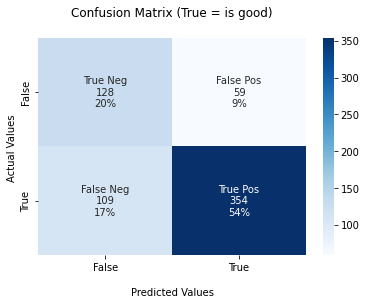

In [ ]:
def plot_cf_matrix(cf_matrix):
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.0%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
  ax.set_title('Confusion Matrix (True = is good)\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

plot_cf_matrix(metrics.confusion_matrix(y_pred, y_test))

## Observações finais e propostas de próximos passos 
O modelo Logístico aplicado para prever vinho "bom" ou "ruim" se mostrou superior ao desempenho do modelo linear para previsão de nota da qualidade, conforme verificado no desempenho dos modelos sob a base de teste. Em parte tal superioridade se deve à qualidade ser uma variavel discreta, tal tipo de variável se aplica melhor à proposta do modelo logístico. Mas a melhoria também se deve à simplificação do nosso *Target*. Um target simples com apenas duas características é por natureza mais simples que um conjunto de 7 classes ordinais. Resultando em uma tarefa mais simples.

Nosso desempenho de aplicação de nota foi fraco. Também o desempenho de identificação de vinhos ruins foi praticamente 50% (quase-aleatório). Esse desempenho nos leva para o ponto primordial: **A perspectiva do negócio.** 
- O que se busca alcançar atraves de um modelo? 
- Ou ainda mais, de que forma um determinado modelo pode ajudar o negócio? 
- Buscamos apenas métricas ou para além disso: agregar valor? 

O nosso modelo logístico mostrou forte **Precisão**. A interpretação adequada desse desempenho agrega um valor definitivo para o uso em negócio, independente das outras métrica. Nosso modelo permite, através dos dados fisicoquímicos, sugerir um vinho que muito provavelmente será bom (cerca de 75% de certeza). Tal classificação serviria tando para uma pessoa física descobrir vinhos que provavelmente irá gostar, quanto serviria para uma empresa do ramo mapear vinhos de qualidade - por exemplo, para a revenda. 

O uso do modelo pode gerar significativa **redução de custos** para uma empresa que busque encontrar vinhos bons. No exemplo da nossa base de teste, a empresa não precisaria atuar sobre os 650 vinhos com uma taxa de descobrimento de vinhos bons de 71%. O processo de experimentar  poderia ser realizado apenas sobre os 413 vinhos preditos pelo modelo com uma de taxa de descobrimento de vinhos bons de 86%.
lguem 

**Algumas medidas permanecem como sugestões prioritárias de melhorias para o trabalho de pesquisa:**
- Aprimorar a robustez do modelo a variações nos dados. Este resultado pode ser obtido através da parametrização e treinamento do modelo com base em métodos como o `KFold` e o `GridSearch`. Tal abordagem pode vir a sanar a dificuldade de *overfitting* encontrada no modelo linear. Outra opção é a utilização de modelos com menos *features*, reduzindo o impacto da multicolinearidade.

- Comparar o desempenho do modelo logistico contra um modelo aleatório baseado na distribuição "bom"x"ruim" dos dados de treino. Como parece haver mais vinhos "Bons" do que vinhos "Ruins", Precisamos verificar se nosso modelo logistestatísticamente ico é superior a um "chute" alea ou se o desempenho foi apenas "sorte".tório.



**Outras sugestões de melhorias para o trabalho são:**

- Realizar o *split* dos dados de teste com auxílio da extratificação por qualidade dos resultados. Garantindo assim um balanceamento adequado entre treino e teste dos pontos extremos de qualidade que possuem baixa incidência.

- Realizar os tratamentos de *outliers* de modo extratificado. Ou seja, apesar dos *outliers* gerais terem sido identificados como os pontos de notas extremos, é possível que seja possível melhorar o desempenho do treinamento do sistema - se a existência de outliers for identificada quando analisarmos individualmente cada categoria de Qualidade.

- Utilização de outros modelos não indicados para o exercício que sejam mais adequados ao perfil dos dados como por exemplo `Naive Bayes`, `Support Vector Machine` e `Random Forest`.  

- Incluir um balanceamento artificial dos dados de treino com base em suas extratificações de nota de qualidade. Tal mudança poderá aumentar a influência dos pontos extremos de qualidade sobre o modelo, corrigindo assim a tendencia dos nossos modelos de fazer o predict apenas de pontos centrais. Uma forma seria através de um `OverSampling` parcial.

# Saúde!